<a href="https://colab.research.google.com/github/samindelhi/CNN-Exercises/blob/main/TrainingCNNFromScratchwithMNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training CNN from Scratch with MNIST dataset using PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# 1. Load and prepocess MNIST dataset.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0,1] tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalizes with MNIST mean & std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


# 2. Visualize some images.


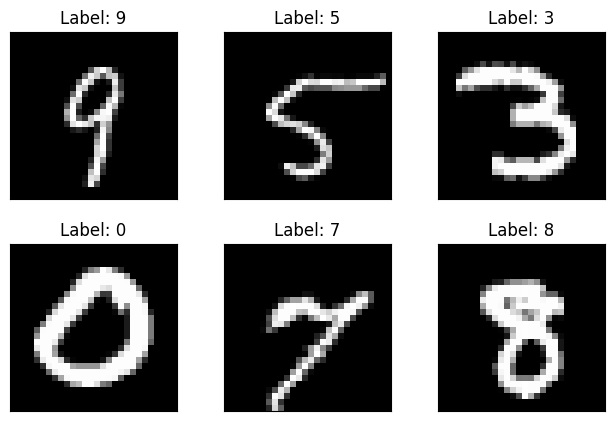

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets)= next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# 3. Define CNN architecture.


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1,32, kernel_size=3)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216,128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))   # [batch, 32, 26, 26]
    x = F.relu(self.conv2(x))   # [batch, 64, 24, 24] - 3x3 kernel was used. reducing 2.
    x = F.max_pool2d(x,2)       # [batch, 64, 12, 12]
    x = self.dropout1(x)
    x = torch.flatten(x,1)      # Flatten all but batch.
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)



In [ ]:
# Model Summary
!pip install torchsummary

# 4. Instantiate model, define optimizer and loss.


In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model, (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


# 5. Training Loop

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data,target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")



# 6. Testing Loop


In [ ]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct=0

  with torch.no_grad():
    for data, target in test_loader:
      data, target= data.to(device), target.to(device)

      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1)
      correct += pred.eq(target).sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)

  print(f"\n Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%) \n")


# 7. Run Training & testing


In [ ]:
for epoch in range(1,6):
  train(model, device, train_loader, optimizer, epoch)
  test(model,device, test_loader)


Train Epoch: 1 [0/60000] Loss: 2.316378
Train Epoch: 1 [6400/60000] Loss: 0.290849
Train Epoch: 1 [12800/60000] Loss: 0.185023
Train Epoch: 1 [19200/60000] Loss: 0.136578
Train Epoch: 1 [25600/60000] Loss: 0.227742
Train Epoch: 1 [32000/60000] Loss: 0.062970
Train Epoch: 1 [38400/60000] Loss: 0.244730
Train Epoch: 1 [44800/60000] Loss: 0.155260
Train Epoch: 1 [51200/60000] Loss: 0.087699
Train Epoch: 1 [57600/60000] Loss: 0.210449

 Test set: Average loss: 0.0578, Accuracy: 9800/10000 (98.00%) 

Train Epoch: 2 [0/60000] Loss: 0.067757
Train Epoch: 2 [6400/60000] Loss: 0.224796
Train Epoch: 2 [12800/60000] Loss: 0.267201
Train Epoch: 2 [19200/60000] Loss: 0.064704
Train Epoch: 2 [25600/60000] Loss: 0.046581
Train Epoch: 2 [32000/60000] Loss: 0.180338
Train Epoch: 2 [38400/60000] Loss: 0.138261
Train Epoch: 2 [44800/60000] Loss: 0.155739
Train Epoch: 2 [51200/60000] Loss: 0.104919
Train Epoch: 2 [57600/60000] Loss: 0.049084

 Test set: Average loss: 0.0389, Accuracy: 9876/10000 (98.76%) 

# 8. Save the Trained Model.

In [ ]:
model_path = "mnist_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to mnist_cnn.pth


# 9. Load the Saved Model

In [ ]:
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Model loaded successfully...")

Model loaded successfully...


# 10. Make prediction with loaded model.


In [ ]:
def predict(model, device, data_loader, num_samples=6):
  model.eval()
  data_iter = iter(data_loader)
  images, labels = next(data_iter)
  images, labels = images.to(device), labels.to(device)
  output = model(images)
  preds = output.argmax(dim=1)

  # Visualize predictions
  fig = plt.figure()
  for i in range(num_samples):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title(f"Pred: {preds[i].item()}, Label: {labels[i].item()}")
    plt.xticks([])
    plt.yticks([])
  plt.show()


# 11. Run Prediction.

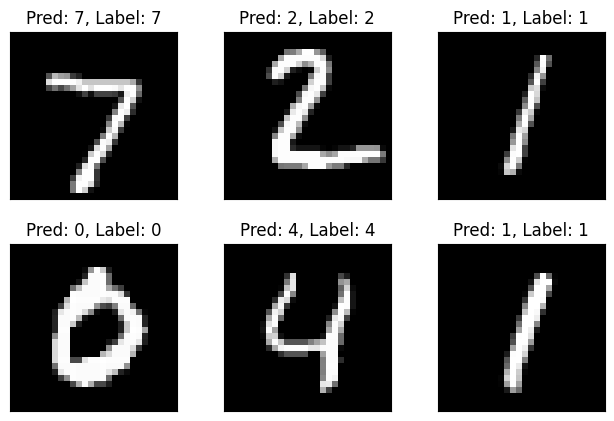

In [ ]:
predict(loaded_model, device, test_loader)